In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    RandomForestClassifier,
    StackingClassifier,
    VotingClassifier,
)
from sklearn.feature_selection import SelectKBest, VarianceThreshold, chi2
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    Binarizer,
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    RobustScaler,
    StandardScaler,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [69]:
# marche pas avec un xls il faut le convertir en xlsx
data = pd.read_excel("titanic3.xlsx")


In [70]:
data

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,"Zabour, Miss. Hileni",female,14.5000,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN
1305,3,0,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3,0,"Zakarian, Mr. Ortin",male,27.0000,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN


In [71]:
data[data["fare"] == data["fare"].max()]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
49,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C,3,NaN,"Austria-Hungary / Germantown, Philadelphia, PA"
50,1,1,"Cardeza, Mrs. James Warburton Martinez (Charlo...",female,58.0,0,1,PC 17755,512.3292,B51 B53 B55,C,3,NaN,"Germantown, Philadelphia, PA"
183,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C,3,NaN,NaN
302,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C,3,NaN,NaN


survival - Survival (0 = No; 1 = Yes)\
class - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)\
name - Name\
sex - Sex\
age - Age\
sibsp - Number of Siblings/Spouses Aboard\
parch - Number of Parents/Children Aboard\
ticket - Ticket Number\
fare - Passenger Fare\
cabin - Cabin\
embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)\
boat - Lifeboat (if survived)\
body - Body number (if did not survive and body was recovered)

In [72]:
data.isna().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In [73]:
data = data.drop(columns=["boat", "body", "cabin", "name", "home.dest", "ticket"])

In [74]:
data.embarked.value_counts()

embarked
S    914
C    270
Q    123
Name: count, dtype: int64

In [75]:
data.isna().sum()

pclass        0
survived      0
sex           0
age         263
sibsp         0
parch         0
fare          1
embarked      2
dtype: int64

In [76]:
data.dtypes

pclass        int64
survived      int64
sex          object
age         float64
sibsp         int64
parch         int64
fare        float64
embarked     object
dtype: object

In [77]:
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,female,29.0000,0,0,211.3375,S
1,1,1,male,0.9167,1,2,151.5500,S
2,1,0,female,2.0000,1,2,151.5500,S
3,1,0,male,30.0000,1,2,151.5500,S
4,1,0,female,25.0000,1,2,151.5500,S


## Préparation des pipelines pour le préprocessing

In [78]:
X = data.drop(columns="survived")
y = data.survived

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Nous avons plusieurs transformation a effectuer, nous allons donc préparer différents pipeline afin de traiter nos colonnes par type

Imputer : Nous avons 3 colonnes avec des valeurs vides ( age , fare , embarked ).

        Nous allons donc commencer par imputer des valeurs dans ces champs vide.

        SimpleImputer --> Age , fare --> Mean
        SimpleImputer --> Embarked  --> Most Frequent ( variable catégorielle ) "le mode en gros "

scaler : Nous pouvons normaliser les colonnes ( Age et Fare )

        StandardScaler --> Age , Fare

Encoder : Nous avons deux colonnes encodable ( sex et embarked )

        OneHotEncoder --> Embarked , sex

        

In [ ]:
embarkedpipe = make_pipeline(
    SimpleImputer(strategy="most_frequent"), OneHotEncoder(drop="first")
)  # on lui passe une série de modèles à appliquer d'affilée

agefarepipe = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())

transformer = make_column_transformer(
    (embarkedpipe, ["embarked", "sex"]),
    (agefarepipe, ["age", "fare"]),
    remainder="passthrough",
)
# model2 = make_pipeline(transformer, DecisionTreeClassifier()) #ici on peut changer le modèle pour un decision tree
model = make_pipeline(transformer, SVC())

model.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['embarked', 'sex']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fare'])])),
                ('svc', SVC())])

In [81]:
model.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(drop='first'))]),
                                    ['embarked', 'sex']),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    ['age', 'fare'])])),
  ('svc', SVC())],
 'verbose': False,
 'columntransformer': ColumnTransformer(remai

In [ ]:
model.score(X_test, y_test)  # accuracy , % of good results on total restults


0.7824427480916031

In [122]:
params2 = {"svc__degree": [1, 2, 3, 4, 5]}

In [123]:
params = {
    "decisiontreeclassifier__criterion": ["gini", "entropy", "log_loss"],
    "decisiontreeclassifier__max_depth": [50, 100, 150],
}

grid = GridSearchCV(estimator=model, param_grid=params2, cv=5, scoring="accuracy")
# ici on utilise pas les DecisionTreeClassifier car on a défini un SVC plus haut dans le pipeline
# cv = cross validation en gros il va faire l'entrainement sur 5 jeu de données


In [85]:
model = grid.fit(X_train, y_train)

In [118]:
grid.best_params_

{'svc__degree': 1}

In [87]:
model.score(X_test, y_test)

0.7824427480916031

In [88]:
y_pred_pipeline = model.predict(X_test)
accuracy_score(y_test, y_pred_pipeline)

0.7824427480916031

In [89]:
print(classification_report(y_test, y_pred_pipeline))

              precision    recall  f1-score   support

           0       0.77      0.87      0.81       144
           1       0.81      0.68      0.74       118

    accuracy                           0.78       262
   macro avg       0.79      0.77      0.78       262
weighted avg       0.79      0.78      0.78       262



<Axes: >

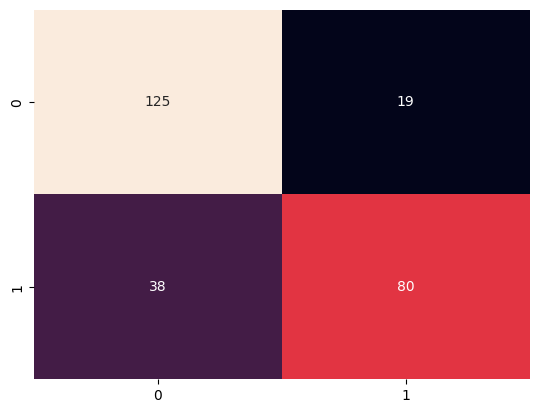

In [ ]:
sns.heatmap(
    confusion_matrix(y_test, y_pred_pipeline), annot=True, cbar=False, fmt=".3g"
)
# fmt=".3g" pour afficher les valeur sur 3 chiffres


en gros la matrice de confusion se lit comme suit: sur la diagonale \ on considère comme vraie : x= predict et y= resultat , en gros quand notre modèle à prédit un 1 , on a eu 80 1 et 19 0 , etc 


In [91]:
testmodel = make_pipeline(transformer, DecisionTreeClassifier())
testmodel.fit(X_train, y_train)
testmodel[1]

DecisionTreeClassifier()

---------

# Ensemble learning

Les ensembles sont des modèles d'entrainement combinant plusieurs modèles afin de maximiser l'efficacité de la prédiction.

Voici les principales méthodes d'ensemble en machine learning :

    Bagging (Bootstrap Aggregating) : Entraîne plusieurs modèles indépendants sur des sous-échantillons des données (tirages avec remplacement) et combine leurs prédictions (ex : RandomForestclassifier).

    Boosting : Entraîne des modèles séquentiels, chaque modèle corrigeant les erreurs du précédent. Les modèles sont combinés pour améliorer la performance (ex : AdaBoost, Gradient Boosting).

    Stacking : Combine plusieurs modèles (niveaux inférieurs) et utilise un méta-modèle pour apprendre à partir de leurs prédictions.
    
    Voting : Combine les prédictions de plusieurs modèles (classificateurs ou régressions) en votant pour la prédiction majoritaire (hard voting) ou en moyennant les probabilités (soft voting).

## RandomForestClassifier

In [92]:
rfcmodel = make_pipeline(transformer, RandomForestClassifier(n_estimators=300))
rfcmodel.fit(X_train, y_train)
rfcmodel.score(X_test, y_test)

0.7977099236641222

In [93]:
paramsrfc = {
    "randomforestclassifier__max_depth": [50, 100, 150, 200],
    "randomforestclassifier__criterion": ["gini", "entropy"],
}

gridrfc = GridSearchCV(rfcmodel, paramsrfc, cv=5, scoring="accuracy")
finalrfcmodel = gridrfc.fit(X_train, y_train)
finalrfcmodel.score(X_test, y_test)


0.8053435114503816

In [94]:
gridrfc.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(drop='first'))]),
                                    ['embarked', 'sex']),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    ['age', 'fare'])])),
  ('randomforestclassifier', R

## Bagging

Reprenons notre transformer precédent et comparons un modèle simple contre un modèle de bagging.

In [95]:
simplemodel = make_pipeline(transformer, KNeighborsClassifier())
simplemodel.fit(X_train, y_train)
simplemodel.score(X_test, y_test)

0.7519083969465649

Testons maintenant le même modèle dans un baggingclassifier.

In [96]:
bagmodel = make_pipeline(
    transformer, BaggingClassifier(estimator=KNeighborsClassifier(), n_estimators=100)
)  # BaggingClassifier default estimator = DecisionTreeClassifier
bagmodel.fit(X_train, y_train)
bagmodel.score(X_test, y_test)


0.7519083969465649

In [97]:
paramskneig = {
    "baggingclassifier__estimator__n_neighbors": [3, 5, 7],
    "baggingclassifier__estimator__weights": ["uniform", "distance"],
    "baggingclassifier__estimator__p": [1, 2],
}

gridKneig = GridSearchCV(bagmodel, paramskneig, cv=5, scoring="accuracy")
finalbagmodel = gridKneig.fit(X_train, y_train)
finalbagmodel.score(X_test, y_test)


0.767175572519084

In [98]:
gridKneig.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(drop='first'))]),
                                    ['embarked', 'sex']),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    ['age', 'fare'])])),
  ('baggingclassifier',
   Bag

## Boosting

In [99]:
boostmodel = make_pipeline(
    transformer,
    AdaBoostClassifier(
        estimator=DecisionTreeClassifier(), n_estimators=200, algorithm="SAMME"
    ),
)
boostmodel.fit(X_train, y_train)
boostmodel.score(X_test, y_test)


0.7977099236641222

In [100]:
paramsboost = {
    "adaboostclassifier__estimator__max_depth": [50, 100, 150, 250, 350],
    "adaboostclassifier__estimator__criterion": ["gini", "entropy"],
}

gridboost = GridSearchCV(boostmodel, paramsboost, cv=5, scoring="accuracy")
finalboostmodel = gridboost.fit(X_train, y_train)
finalboostmodel.score(X_test, y_test)


0.7938931297709924

In [101]:
gridboost.best_params_

{'adaboostclassifier__estimator__criterion': 'gini',
 'adaboostclassifier__estimator__max_depth': 150}

## Stacking

In [102]:
estimators = [
    ("knn", KNeighborsClassifier()),
    ("svm", SVC()),
    ("sgd", SGDClassifier()),
    ("logreg", LogisticRegression()),
    ("dt", DecisionTreeClassifier()),
]


stackmodel = make_pipeline(
    transformer,
    StackingClassifier(
        estimators=estimators, final_estimator=DecisionTreeClassifier(), cv=5
    ),
)
stackmodel.fit(X_train, y_train)
stackmodel.score(X_test, y_test)


0.7290076335877863

In [103]:
paramsstack = {
    "stackingclassifier__final_estimator__max_depth": [
        50,
        100,
        150,
        250,
        350,
    ],  # Paramètres du final_estimator (DecisionTree)
    "stackingclassifier__final_estimator__criterion": [
        "gini",
        "entropy",
    ],  # Paramètre 'criterion' pour le final_estimator
    "stackingclassifier__dt__max_depth": [50, 100, 150, 250, 350],
}

gridstack = GridSearchCV(stackmodel, paramsstack, cv=5, scoring="accuracy")
finalstackmodel = gridstack.fit(X_train, y_train)
finalstackmodel.score(X_test, y_test)


0.7099236641221374

In [104]:
gridstack.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(drop='first'))]),
                                    ['embarked', 'sex']),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    ['age', 'fare'])])),
  ('stackingclassifier',
   St

In [105]:
finalstackmodel = gridstack.fit(X_train, y_train)
finalstackmodel.score(X_test, y_test)

0.732824427480916

Fonctionnement du StackingClassifier :

    Modèles de base : Ces modèles sont entraînés séparément sur les mêmes données d'entraînement. Leurs prédictions sont ensuite combinées.
    
    Modèle final (meta-estimator) : Il apprend à partir des prédictions des modèles de base. Le modèle final peut être un modèle plus simple ou complexe, mais son rôle est de pondérer les prédictions des modèles de base pour améliorer la précision globale.

Cependant, la sélection des modèles de base et du modèle final a de l'importance :

    Nous devons choisir des modèles de base qui sont suffisamment diversifiés pour qu'ils apportent des prédictions complémentaires (ils ne doivent pas tous faire exactement les mêmes erreurs).
    
    Le modèle final doit être capable d'exploiter efficacement ces différentes prédictions.

Quand utiliser chaque méthode ?

    Bagging :
        Quand le modèle souffre de haute variance (comme un arbre de décision non régularisé).
        Quand vous avez des ensembles de données volumineux.
        Quand vous voulez un modèle robuste, facilement parallélisable.

    Boosting :
        Si vous avez un modèle simple qui a un biais élevé.
        Si vous cherchez à maximiser la précision et que vous êtes prêt à passer du temps à affiner les hyperparamètres.
        Quand vous avez des ensembles de données relativement plus petits et complexes.

    Stacking :
        Si vous voulez combiner des modèles différents pour maximiser la performance.
        Quand vous avez un ensemble de données varié et que vous voulez tirer parti de la diversité des modèles.
        Si vous disposez de ressources de calcul suffisantes et que vous êtes prêt à faire face à une mise en œuvre plus complexe.

Conclusion :

    Si votre priorité est de réduire le surajustement et que vous avez un grand ensemble de données, le bagging (comme le Random Forest) est un bon choix.

    Si vous avez besoin de réduire à la fois le biais et la variance et que la précision est essentielle, le boosting (comme XGBoost) est souvent la meilleure option.
    
    Si vous voulez combiner plusieurs modèles pour maximiser les performances et exploiter la complémentarité des modèles, le stacking est puissant mais plus complexe à mettre en œuvre.

### Il reste un modele ensembliste, le VotingClassifier. A vous de le tester !!! Et pourquoi pas avec un RandomizedSearchCV



-------------------------

| Critère          | Bagging                                   | Boosting                               | Stacking                             |
|------------------|-------------------------------------------|---------------------------------------|--------------------------------------|
| **Biais/Variance**       | Réduit la variance                         | Réduit biais et variance              | Combine les forces de différents modèles |
| **Overfitting**      | Réduit le surajustement                  | Tendance à surajuster si mal réglé    | Risque d'overfitting si mal implémenté |
| **Parallélisation**  | Facile à paralléliser                     | Difficile (processus séquentiel)     | Plus complexe (nécessite CV)        |
| **Performance**      | Bonne sur modèles à haute variance        | Très performant si bien réglé         | Potentiellement supérieur            |
| **Interprétabilité** | Assez facile (Random Forest)              | Plus difficile à interpréter          | Plus complexe                        |
| **Données**          | Grand ensemble de données                 | Ensemble de données moyen             | Fonctionne sur des ensembles mixtes   |
| **Exemples**         | Random Forest                             | XGBoost, AdaBoost                    | Mélange de différents modèles        |


--------------

## Feature Selection

reprennons nos datas de base. 

In [106]:
Xbis = X

In [107]:
Xbis

,pclass,sex,age,sibsp,parch,fare,embarked
0,1,female,29.0000,0,0,211.3375,S
1,1,male,0.9167,1,2,151.5500,S
2,1,female,2.0000,1,2,151.5500,S
3,1,male,30.0000,1,2,151.5500,S
4,1,female,25.0000,1,2,151.5500,S
...,...,...,...,...,...,...,...
1304,3,female,14.5000,1,0,14.4542,C
1305,3,female,NaN,1,0,14.4542,C
1306,3,male,26.5000,0,0,7.2250,C
1307,3,male,27.0000,0,0,7.2250,C


In [108]:
Xbis_encoded = pd.get_dummies(
    Xbis, columns=["sex", "embarked"], drop_first=True, dtype=int
)  # get_dummies permet d'encoder les variables catégorielle
Xbis_encoded  # drop_first = supprimer la premiere colonne encodée
# dtype default = bool


,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
0,1,29.0000,0,0,211.3375,0,0,1
1,1,0.9167,1,2,151.5500,1,0,1
2,1,2.0000,1,2,151.5500,0,0,1
3,1,30.0000,1,2,151.5500,1,0,1
4,1,25.0000,1,2,151.5500,0,0,1
...,...,...,...,...,...,...,...,...
1304,3,14.5000,1,0,14.4542,0,0,0
1305,3,NaN,1,0,14.4542,0,0,0
1306,3,26.5000,0,0,7.2250,1,0,0
1307,3,27.0000,0,0,7.2250,1,0,0


In [109]:
Xbis_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pclass      1309 non-null   int64  
 1   age         1046 non-null   float64
 2   sibsp       1309 non-null   int64  
 3   parch       1309 non-null   int64  
 4   fare        1308 non-null   float64
 5   sex_male    1309 non-null   int32  
 6   embarked_Q  1309 non-null   int32  
 7   embarked_S  1309 non-null   int32  
dtypes: float64(2), int32(3), int64(3)
memory usage: 66.6 KB


In [110]:
Xbis_encoded.fillna(
    {"age": Xbis_encoded["age"].mean(), "fare": Xbis_encoded["fare"].mean()},
    inplace=True,
)  # Fill des valeurs null par la moyenne


In [111]:
Xbis_encoded

,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
0,1,29.000000,0,0,211.3375,0,0,1
1,1,0.916700,1,2,151.5500,1,0,1
2,1,2.000000,1,2,151.5500,0,0,1
3,1,30.000000,1,2,151.5500,1,0,1
4,1,25.000000,1,2,151.5500,0,0,1
...,...,...,...,...,...,...,...,...
1304,3,14.500000,1,0,14.4542,0,0,0
1305,3,29.881135,1,0,14.4542,0,0,0
1306,3,26.500000,0,0,7.2250,1,0,0
1307,3,27.000000,0,0,7.2250,1,0,0


In [112]:
chi2(Xbis_encoded, y)

(array([3.90643317e+01, 1.83082968e+01, 2.20271805e+00, 1.73899276e+01,
        6.27155735e+03, 1.30254635e+02, 3.06334549e-01, 9.43584915e+00]),
 array([4.10067763e-10, 1.87887103e-05, 1.37767628e-01, 3.04434998e-05,
        0.00000000e+00, 3.60442736e-30, 5.79938211e-01, 2.12784544e-03]))

In [113]:
Xbis_train, Xbis_test, ybis_train, ybis_test = train_test_split(
    Xbis_encoded, y, test_size=0.2, random_state=42
)


## VarianceThreshold

Selection de colonnes sur base de la variance.

In [114]:
varselector = VarianceThreshold(threshold=0.1)
varselector.fit_transform(Xbis_train, ybis_train)
varselector.get_support()  # Permet de voir la ou les colonnes supprimée après la selection ( True = gardée , False = supprimée)

array([ True,  True,  True,  True,  True,  True, False,  True])

In [115]:
Xbis_encoded.columns[varselector.get_support()]

Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_male', 'embarked_S'], dtype='object')

Suppression de la colonne embarked_Q car la variance était inférieure a 0.1 (threshold).

Ici nous faisons ca juste pour la démonstration, dans la pratique, rappelons nous que les colonnes "embarked" viennent à la base de l'encodage d'une colonne catégorielle, lors de l'encodage, nous avons déjà supprimé une colonne "embarked" pour évité la multicolinéarité. Il est donc maintenant peu recommandé de supprimer une autre de ces colonnes sous peine de perdre une partie de l'information.

## SelectKbest

In [116]:
kbestselector = SelectKBest(
    score_func=chi2, k=5
)  # Selectionne les 5 meilleurs variables / f_classif = fonctionne de scoring par défaut
kbestselector.fit_transform(Xbis_train, ybis_train)
kbestselector.get_support()


array([ True,  True, False,  True,  True,  True, False, False])

In [117]:
Xbis_encoded.columns[kbestselector.get_support()]

Index(['pclass', 'age', 'parch', 'fare', 'sex_male'], dtype='object')